In [6]:
!pip install --force-reinstall smolagents torch ipywidgets transformers sympy numpy matplotlib seaborn

  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached transformers-4.48.0-py3-none-any.whl.metadata (44 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-2.2.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached markdownify-0.14.1-py3-none-any.whl.metadata (8.5 kB)

In [4]:
!pip install pybind11>=2.12

In [5]:
import datasets
import pandas as pd

eval_ds = datasets.load_dataset("m-ric/smol_agents_benchmark")["test"].select(range(3))
pd.DataFrame(eval_ds)

,question,source,true_answer,true_reasoning
0,If Eliud Kipchoge could maintain his record-ma...,GAIA,17,None
1,How many studio albums were published by Merce...,GAIA,3,None
2,Here's a fun riddle that I think you'll enjoy....,GAIA,3,None


### Define utilities and tools
To run the SERPAPI tool, you will need to have a [SerpAPI](https://serpapi.com/dashboard) API key: for this you need a paid account.

In [6]:
import time
import json
import os
import re
import string
import warnings
from tqdm import tqdm
from typing import List

from smolagents import (
    GoogleSearchTool,
    CodeAgent,
    ToolCallingAgent,
    HfApiModel,
    AgentError,
    VisitWebpageTool,
    PythonInterpreterTool,
    TransformersModel
)
from smolagents.agents import ActionStep
from dotenv import load_dotenv

load_dotenv()
os.makedirs("output", exist_ok=True)


def serialize_agent_error(obj):
    if isinstance(obj, AgentError):
        return {"error_type": obj.__class__.__name__, "message": obj.message}
    else:
        return str(obj)


def answer_questions(
    eval_ds, file_name, agent, model_id, action_type, is_vanilla_llm=False
):
    answered_questions = []
    if os.path.exists(file_name):
        with open(file_name, "r") as f:
            for line in f:
                answered_questions.append(json.loads(line)["question"])

    for _, example in tqdm(enumerate(eval_ds), total=len(eval_ds)):
        try:
            print(example)
            question = example["question"]
            if example["source"] == "SimpleQA":
                question += " Answer with only the final number."
            if example["source"] == "MATH":
                question += " Write code, not latex."
            if question in answered_questions:
                continue
            start_time = time.time()

            if is_vanilla_llm:
                llm = agent
                answer = llm([{"role": "user", "content": question}])
                token_count = llm.last_input_token_count + llm.last_output_token_count
                intermediate_steps = []
            else:
                answer = agent.run(question)
                token_count = agent.monitor.get_total_token_counts()
                intermediate_steps = str(agent.logs)
                # Remove memory from logs to make them more compact.
                for step in agent.logs:
                    if isinstance(step, ActionStep):
                        step.agent_memory = None

            end_time = time.time()
            annotated_example = {
                "model_id": model_id,
                "agent_action_type": action_type,
                "question": question,
                "answer": answer,
                "true_answer": example["true_answer"],
                "source": example["source"],
                "intermediate_steps": intermediate_steps,
                "start_time": start_time,
                "end_time": end_time,
                "token_counts": token_count,
            }

            with open(file_name, "a") as f:
                json.dump(annotated_example, f, default=serialize_agent_error)
                f.write("\n")  # add a newline for JSONL format
        except Exception as e:
            print("Failed:", e)


def normalize_number_str(number_str: str) -> float:
    # we replace these common units and commas to allow
    # conversion to float
    for char in ["$", "%", ","]:
        number_str = number_str.replace(char, "")
    try:
        return float(number_str)
    except ValueError:
        return float("inf")


def split_string(
    s: str,
    char_list: list[str] = [",", ";"],
) -> list[str]:
    pattern = f"[{''.join(char_list)}]"
    return re.split(pattern, s)


def is_float(element: any) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False


def normalize_str(input_str, remove_punct=True) -> str:
    """
    Normalize a string by:
    - Removing all white spaces
    - Optionally removing punctuation (if remove_punct is True)
    - Converting to lowercase
    Parameters:
    - input_str: str, the string to normalize
    - remove_punct: bool, whether to remove punctuation (default: True)
    Returns:
    - str, the normalized string
    """
    # Remove all white spaces. Required e.g for seagull vs. sea gull
    no_spaces = re.sub(r"\s", "", input_str)

    # Remove punctuation, if specified.
    if remove_punct:
        translator = str.maketrans("", "", string.punctuation)
        return no_spaces.lower().translate(translator)
    else:
        return no_spaces.lower()


def extract_numbers(text: str) -> List[str]:
    """This pattern matches:
    - Optional negative sign
    - Numbers with optional comma thousand separators
    - Optional decimal points with decimal numbers
    """
    pattern = r"-?(?:\d{1,3}(?:,\d{3})+|\d+)(?:\.\d+)?"

    return [el.replace(",", "") for el in re.findall(pattern, text)]


def get_question_score_gaia(
    model_answer: str,
    ground_truth: str,
) -> bool:
    """Scoring function used to score functions from the GAIA benchmark"""
    if is_float(ground_truth):
        normalized_answer = normalize_number_str(str(model_answer))
        return normalized_answer == float(ground_truth)

    elif any(char in ground_truth for char in [",", ";"]):  # if gt is a list
        # question with the fish: normalization removes punct
        gt_elems = split_string(ground_truth)
        ma_elems = split_string(model_answer)

        if len(gt_elems) != len(ma_elems):  # check length is the same
            warnings.warn(
                "Answer lists have different lengths, returning False.", UserWarning
            )
            return False

        comparisons = []
        for ma_elem, gt_elem in zip(
            ma_elems, gt_elems
        ):  # compare each element as float or str
            if is_float(gt_elem):
                normalized_ma_elem = normalize_number_str(ma_elem)
                comparisons.append(normalized_ma_elem == float(gt_elem))
            else:
                # we do not remove punct since comparisons can include punct
                comparisons.append(
                    normalize_str(ma_elem, remove_punct=False)
                    == normalize_str(gt_elem, remove_punct=False)
                )
        return all(comparisons)

    else:  # if gt is a str
        return normalize_str(model_answer) == normalize_str(ground_truth)

## Benchmark agents

### Open models

In [8]:
open_model_ids = [
    #"meta-llama/Llama-3.3-70B-Instruct",
    # "Qwen/QwQ-32B-Preview",
    #"Qwen/Qwen2.5-72B-Instruct",
    #"Qwen/Qwen2.5-Coder-32B-Instruct",
    #"meta-llama/Llama-3.2-3B-Instruct",
    #"meta-llama/Llama-3.1-8B-Instruct",
    #"mistralai/Mistral-Nemo-Instruct-2407",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    # "meta-llama/Llama-3.1-70B-Instruct",
    "HuggingFaceTB/SmolLM-1.7B-Instruct"
]

for model_id in open_model_ids:
    print(f"Evaluating '{model_id}'...")
    # action_type = "tool_calling"
    # agent = ToolCallingAgent(
    #     tools=[GoogleSearchTool(), VisitWebpageTool(), PythonInterpreterTool()],
    #     model=HfApiModel(model_id),
    #     max_steps=10,
    # )
    # file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    # answer_questions(eval_ds, file_name, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        #model=HfApiModel(model_id),
        model=TransformersModel(),
        additional_authorized_imports=["numpy", "sympy"],
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = HfApiModel(model_id)
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(
        eval_ds, file_name, llm, model_id, action_type, is_vanilla_llm=True
    )

`model_id`not provided, using this default tokenizer for token counts: 'HuggingFaceTB/SmolLM2-1.7B-Instruct'


Evaluating 'HuggingFaceTB/SmolLM-1.7B-Instruct'...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 5893.64it/s]


{'question': 'If Eliud Kipchoge could maintain his record-making marathon pace indefinitely, how many thousand hours would it take him to run the distance between the Earth and the Moon its closest approach? Please use the minimum perigee value on the Wikipedia page for the Moon when carrying out your calculation. Round your result to the nearest 1000 hours and do not use any comma separators if necessary.', 'source': 'GAIA', 'true_answer': '17', 'true_reasoning': 'None'}
{'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'source': 'GAIA', 'true_answer': '3', 'true_reasoning': 'None'}
{'question': 'Here\'s a fun riddle that I think you\'ll enjoy.\n\nYou have been selected to play the final round of the hit new game show "Pick That Ping-Pong". In this round, you will be competing for a large cash prize. Your job will be to pick one of several different numbered ping-pong balls

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 13530.01it/s]

{'question': 'If Eliud Kipchoge could maintain his record-making marathon pace indefinitely, how many thousand hours would it take him to run the distance between the Earth and the Moon its closest approach? Please use the minimum perigee value on the Wikipedia page for the Moon when carrying out your calculation. Round your result to the nearest 1000 hours and do not use any comma separators if necessary.', 'source': 'GAIA', 'true_answer': '17', 'true_reasoning': 'None'}
{'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'source': 'GAIA', 'true_answer': '3', 'true_reasoning': 'None'}
{'question': 'Here\'s a fun riddle that I think you\'ll enjoy.\n\nYou have been selected to play the final round of the hit new game show "Pick That Ping-Pong". In this round, you will be competing for a large cash prize. Your job will be to pick one of several different numbered ping-pong balls

## Closed models

In [ ]:
from smolagents import LiteLLMModel

litellm_model_ids = ["gpt-4o", "anthropic/claude-3-5-sonnet-latest"]

for model_id in litellm_model_ids:
    print(f"Evaluating '{model_id}'...")
    action_type = "tool_calling"
    agent = ToolCallingAgent(
        tools=[
            GoogleSearchTool(),
            VisitWebpageTool(),
            PythonInterpreterTool(["numpy", "sympy"]),
        ],
        model=LiteLLMModel(model_id),
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    action_type = "code"
    agent = CodeAgent(
        tools=[GoogleSearchTool(), VisitWebpageTool()],
        model=LiteLLMModel(model_id),
        additional_authorized_imports=["numpy", "sympy"],
        max_steps=10,
    )
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(eval_ds, file_name, agent, model_id, action_type)

    # Also evaluate vanilla model
    action_type = "vanilla"
    llm = LiteLLMModel(model_id)
    file_name = f"output/{model_id.replace('/', '_')}-{action_type}-26-dec-2024.jsonl"
    answer_questions(
        eval_ds, file_name, llm, model_id, action_type, is_vanilla_llm=True
    )

In [8]:
# import glob
# import json

# jsonl_files = glob.glob(f"output/*.jsonl")

# for file_path in jsonl_files:
#     if "-Nemo-" in file_path and "-vanilla-" in file_path:
#         print(file_path)
#         # Read all lines and filter out SimpleQA sources
#         filtered_lines = []
#         removed = 0
#         with open(file_path, "r", encoding="utf-8") as f:
#             for line in f:
#                 try:
#                     data = json.loads(line.strip())
#                     data["answer"] = data["answer"]["content"]
#                     # if not any([question in data["question"] for question in eval_ds["question"]]):
#                     #     removed +=1
#                     # else:
#                     filtered_lines.append(json.dumps(data) + "\n")
#                 except json.JSONDecodeError:
#                     print("Invalid line:", line)
#                     continue  # Skip invalid JSON lines
#         print(f"Removed {removed} lines.")
#         # Write filtered content back to the same file
#         with open(
#             str(file_path).replace("-vanilla-", "-vanilla2-"), "w", encoding="utf-8"
#         ) as f:
#             f.writelines(filtered_lines)

## Score answers

In [9]:
import pandas as pd
import glob

res = []
for file_path in glob.glob("output/*.jsonl"):
    data = []
    with open(file_path) as f:
        for line in f:
            try:
                # Use standard json module instead of pandas.json to handle large numbers better
                record = json.loads(line)
                data.append(record)
            except json.JSONDecodeError as e:
                print(f"Error parsing line in {file_path}: {e}")
                continue

    try:
        smoldf = pd.DataFrame(data)
        smoldf["action_type"] = "vanilla" if "-vanilla-" in file_path else "code"
        res.append(smoldf)
    except Exception as e:
        print(f"Error creating DataFrame from {file_path}: {e}")
        continue

result_df = pd.concat(res)


def get_correct(row):
    if row["source"] == "MATH":  # Checks the last number in answer
        numbers_answer = extract_numbers(str(row["answer"]))
        if len(numbers_answer) == 0:
            return False
        return float(numbers_answer[-1]) == float(row["true_answer"])
    else:
        return get_question_score_gaia(str(row["answer"]), str(row["true_answer"]))


result_df["correct"] = result_df.apply(get_correct, axis=1)

result_df = (
    (result_df.groupby(["model_id", "source", "action_type"])[["correct"]].mean() * 100)
    .round(1)
    .reset_index()
)

/tmp/ipykernel_1781839/2348857970.py:166: UserWarning: Answer lists have different lengths, returning False.
  warnings.warn(


In [10]:
pivot_df = result_df.pivot_table(
    index=["model_id", "source"],
    columns=["action_type"],
    values="correct",
    fill_value=float("nan"),
).reset_index()

### Display results

In [11]:
display(pivot_df)

action_type,model_id,source,code,vanilla
0,HuggingFaceTB/SmolLM-1.7B,GAIA,0.0,NaN
1,HuggingFaceTB/SmolLM-1.7B,MATH,0.0,NaN
2,HuggingFaceTB/SmolLM-1.7B,SimpleQA,0.0,NaN
3,HuggingFaceTB/SmolLM-1.7B-Instruct,GAIA,0.0,0.0
4,HuggingFaceTB/SmolLM-1.7B-Instruct,MATH,6.0,NaN
5,HuggingFaceTB/SmolLM-1.7B-Instruct,SimpleQA,0.0,NaN


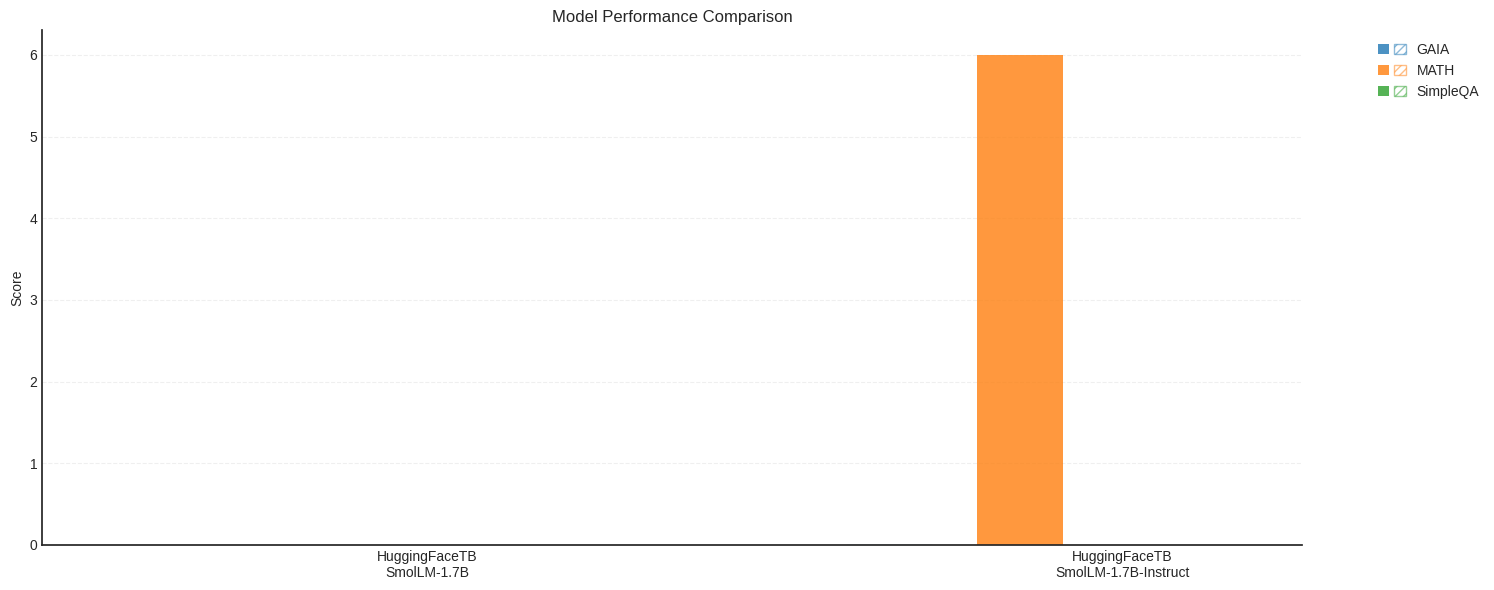

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.legend_handler import HandlerTuple  # Added import

# Assuming pivot_df is your original dataframe
models = pivot_df["model_id"].unique()
sources = pivot_df["source"].unique()

# Create figure and axis
plt.style.use("seaborn-v0_8-white")
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of each bar group and positions of the bars
width = 0.15  # width of each bar
spacing = 0.02  # space between bars within a group
group_spacing = 0.2  # space between model groups

# Calculate positions for the bars
num_sources = len(sources)
total_width_per_group = (width + spacing) * num_sources * 2  # *2 for agent and vanilla
x = np.arange(len(models)) * (total_width_per_group + group_spacing)

# Plot bars for each source
for i, source in enumerate(sources):
    source_data = pivot_df[pivot_df["source"] == source]
    agent_scores = [
        source_data[source_data["model_id"] == model]["code"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]
    vanilla_scores = [
        source_data[source_data["model_id"] == model]["vanilla"].values[0]
        if len(source_data[source_data["model_id"] == model]) > 0
        else np.nan
        for model in models
    ]

    # Position calculation for each pair of bars
    pos = x + i * (width * 2 + spacing)

    agent_bars = ax.bar(pos, agent_scores, width, label=f"{source} (Agent)", alpha=0.8)
    vanilla_bars = ax.bar(
        pos + width * 0.6,
        vanilla_scores,
        width,
        hatch="////",
        alpha=0.5,
        hatch_linewidth=2,
        label=f"{source} (Vanilla)",
        color="white",
        edgecolor=agent_bars[0].get_facecolor(),
    )

# Customize the plot
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")

# Set x-axis ticks in the middle of each group
group_centers = x + (total_width_per_group - spacing) / 2
ax.set_xticks(group_centers)

# Wrap long model names to prevent overlap
wrapped_labels = ["\n".join(model.split("/")) for model in models]
ax.set_xticklabels(wrapped_labels, rotation=0, ha="center")

# Modify legend to combine agent and vanilla entries
handles, labels = ax.get_legend_handles_labels()
unique_sources = sources
legend_elements = [
    (handles[i * 2], handles[i * 2 + 1], labels[i * 2].replace(" (Agent)", ""))
    for i in range(len(unique_sources))
]
custom_legend = ax.legend(
    [
        (agent_handle, vanilla_handle)
        for agent_handle, vanilla_handle, _ in legend_elements
    ],
    [label for _, _, label in legend_elements],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

ax.yaxis.grid(True, linestyle="--", alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

In [12]:
def create_mathjax_table(pivot_df, formatted_df):
    # Start the matrix environment with 4 columns
    # l for left-aligned model and task, c for centered numbers
    mathjax_table = "\\begin{array}{llcc}\n"
    mathjax_table += (
        "\\text{Model} & \\text{Task} & \\text{Agent} & \\text{Vanilla} \\\\\n"
    )
    mathjax_table += "\\hline\n"

    # Sort the DataFrame by model_id and source
    formatted_df = formatted_df.sort_values(["model_id", "source"])

    current_model = None
    for _, row in formatted_df.iterrows():
        model = row["model_id"]
        source = row["source"]

        # Add a horizontal line between different models
        if current_model is not None and current_model != model:
            mathjax_table += "\\hline\n"

        # Format model name
        model_display = model.replace("_", "\\_")
        if "Qwen" in model or "anthropic" in model:
            model_display = f"\\textit{{{model_display}}}"

        # If it's the same model as previous row, use empty space
        if current_model == model:
            model_display = "\\;"

        # Add the data row
        mathjax_table += (
            f"{model_display} & {source} & {row['agent']} & {row['vanilla']} \\\\\n"
        )

        current_model = model

    mathjax_table += "\\hline\n"
    mathjax_table += "\\end{array}"

    return mathjax_table


# Usage (after running your previous data processing code):
mathjax_table = create_mathjax_table(pivot_df, formatted_df)
print(mathjax_table)

NameError: name 'formatted_df' is not defined